[Jupyter Standards &lt;](13_Standards.ipynb) | [&gt; Exploring Interactive Subsets](15_Interactive.ipynb)

# What are users spending the most time on?

Here, we are trying to understand the intent of different cells. For instance, is a given cell for data import, data cleaning and transformation, data visualization, stats modelling, etc? What is the granulaity of work in a cell - are users doing mulltiple activities in a cell, or just one?

*Before running this notebook, time.py must run to completion.*

## Results Summary:
Because this is unsupervised, it’s hard to say which of the three options is best. Even in the deterministic model, there are data manipulation cells that don’t use pandas or numpy that aren’t accounted for. While I don’t think the exact proportions should be taken as truth, the overall patterns were consistent between the models and can give us a good idea of how the data science workflow progresses through a Jupyter Notebook. First, we have imports and data manipulation. After the first 15% or so of cells have passed by, the use of machine learning and visualization grows. At the very end, machine learning takes a dip and visualizations take one last leap. Logic and loops are used throughout the notebook, but least frequent at the very beginning. 

---------

# Import Packages and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from apyori import apriori


import math
import random
import load_data
import datetime
import gensim
import os
import pickle

In [2]:
%%html
<style>
table {float:left}
</style>

In [3]:
all_processed_code = load_data.load_all_processed_code()
print("Processed code for {0} notebooks has been opened.".format(len(all_processed_code)))

Processed code loaded in 0:00:17.752465
Processed code for 1421154 notebooks has been opened.


In [4]:
class_to_color = {
    'Imports': 'navy',
    'Data': 'purple',
    'Logic & Loops': 'black',
    'Machine Learning': 'green',
    'Function': 'crimson',
    'Visualization': 'teal'
}

-----
# Part 1: Limit to Python data science notebooks 

If a notebook imports at least two packages relevant to data science and machine learning (pandas, numpy, matplotlib, seaborn, sklearn, keras, and tensorflow), it is a data science/machine learning notebook.

This was done before the code was preprocessed in time.py. First, the set was limited to the 73.86% of notebooks were written in Python 3. Of those, 44.85% are data science / machine learning notebooks.

----

# Part 2: Tokenize code

Looking at my own notebooks and samples of data science notebooks on GitHub, it's clear that most users have different parts of the data science process in different cells. Futher, there are clues in the code to see what part of the process it belogs to.

*Imports*:
- import statements

*Opening Data*:
- pandas read_csv
- with open

*Function and Class Definitions*:
- def and class statements
- return statements
- lambdas with assignment

*Data Manipulation*:
- dataframe access
- pandas functions (merge, groupby, etc.)

*Modeling*:
- reference a machine learning framework
- framework functions (fit, predict, etc.)

*Visualization*:
- reference a visualization package
- package functions (plot, scatter, chart, etc.)
- has displayed data output key

There are also many cells that will not fall into one of these categories. Further, there are many notebooks that won't necessarily be doing data science. Some notebooks may be in a directory where each file is one step of the process.

## Pre-processing

Add nb_imports column (all imports from the notebook)

- Mark python abstract syntax tree types.
- Replace aliases with what was imported
- Replace:

| In             | Out                             |
|----------------|--------------------------------|
| 1 < 9 | &lt;logic&gt; |
| for i in range(20) | &lt;loop&gt; &lt;loop&gt; |
| pd.read_csv() | pandas read_csv |
| plt.plot(x, y) | &lt;visualization&gt; plot |
| sklearn.linear_model| &lt;framework&gt; linear_model |



- Remove extra symbols ( :,()=[]"'\${}; )
- Split on spaces and periods

----
# Part 3: Classify the tasks of each cell
Identify if cells are for 'imports', 'data cleaning / manipulation', 'modeling', 'visualization', etc. Each cell is allowed to have multiple classifications as long as it fits the criteria for each.

## Deterministic Model
- Imports if there is an import statement
- Visualization if it uses a visualization package
- Machine Learning if it uses a ML package or uses a ML model API call (fit, predict, ...)
- Data if none of the above and uses pandas or numpy
- Other if none of the above

In [5]:
ml_api_calls = [
    'train_test_split',
    'fit',
    'fit_generator',
    'transform',
    'fit_transform',
    'predict',
    'predict_class',
    'predict_generator',
    'predict_on_batch',
    'evaluate',
    'evaluate_generator'
]

def get_distrib_multiclass(nb_records):
    distrib = {
        'place': [],
        'type': []
    }
    total = []
    save_multiclasses = []
    for nb in nb_records:
        i = 0
        multiclasses = []
        for record in nb:
            classes = []
            if record.strip() != '':
                place = round(i/len(nb), 1)
                total.append(place)
                if '<import>' in record:
                    distrib['place'].append(place) 
                    distrib['type'].append('Imports')
                    classes.append('Imports')
                if '<visualization>' in record:
                    distrib['place'].append(place) 
                    distrib['type'].append('Visualization')
                    classes.append('Visualization')
                if '<framework>' in record or sum([m in record for m in ml_api_calls]) > 0:
                    distrib['place'].append(place) 
                    distrib['type'].append('Machine Learning')
                    classes.append('Machine Learning')
                if 'pandas' in record or 'numpy' in record:
                    distrib['place'].append(place) 
                    distrib['type'].append('Data')
                    classes.append('Data')
                if '<function_def>' in record:
                    distrib['place'].append(place) 
                    distrib['type'].append('Function')
                    classes.append('Function')
                if '<logic>' in record or '<loop>' in record:
                    distrib['place'].append(place) 
                    distrib['type'].append('Logic & Loops')
                    classes.append('Logic & Loops')
            i += 1
            multiclasses.append(classes)
        save_multiclasses.append(multiclasses)
    distrib_df = pd.DataFrame(distrib).reset_index().rename(
        columns={'index':'num'}
    ).groupby(['place','type'])['num'].count().reset_index()

    distrib_df = distrib_df.merge(
        pd.Series(total).value_counts().reset_index().rename(columns = {
            'index': 'place', 0:'total'
        }),
        on = 'place'
    )

    distrib_df['prop'] = distrib_df['num'] / distrib_df['total']
    return distrib_df, save_multiclasses

In [6]:
# 3 minutes
start = datetime.datetime.now()

distrib2, save_multiclasses = get_distrib_multiclass(all_processed_code)

end = datetime.datetime.now()
print(end - start)

0:02:59.640685


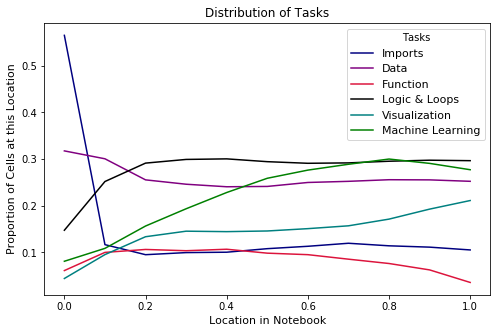

In [7]:
fig = plt.figure(figsize = (8, 5))
for classification in ['Imports','Data','Function','Logic & Loops',
                       'Visualization','Machine Learning']:
    df = distrib2[distrib2.type == classification]
    plt.plot(
        df['place'], df['prop'], 
        color = class_to_color[classification], 
        label = classification
    )
plt.title('Distribution of Tasks', fontsize = 12)
plt.legend(title = 'Tasks', fontsize = 11) # bbox_to_anchor=(1.3, 1)
plt.xlabel('Location in Notebook', fontsize = 11)
plt.ylabel('Proportion of Cells at this Location', fontsize = 11)
plt.show()

In [8]:
print("{0}% of cells fall into at least one category.".format(
    round(100*sum(
            [len([m for m in multi if m != []]) for multi in save_multiclasses]
        )/sum([len(m) for m in save_multiclasses]), 2
    )
))

54.54% of cells fall into at least one category.


In [9]:
all_cells = distrib2.groupby('type')['num'].sum().reset_index()
num_cells = all_cells.num.sum()
all_cells['prop_all'] = all_cells['num']/num_cells
all_cells

,type,num,prop_all
0,Data,7403477,0.228674
1,Function,2576136,0.079570
2,Imports,3866207,0.119417
3,Logic & Loops,8054110,0.248770
4,Machine Learning,6396879,0.197582
5,Visualization,4078937,0.125987


In [10]:
distrib2[distrib2.place == 0]

,place,type,num,total,prop
0,0.0,Data,533813,1680652,0.317623
1,0.0,Function,102545,1680652,0.061015
2,0.0,Imports,950170,1680652,0.565358
3,0.0,Logic & Loops,247868,1680652,0.147483
4,0.0,Machine Learning,136074,1680652,0.080965
5,0.0,Visualization,74009,1680652,0.044036


In [11]:
distrib2[distrib2.place == 0.1]

,place,type,num,total,prop
6,0.1,Data,915388,3044201,0.300699
7,0.1,Function,304386,3044201,0.099989
8,0.1,Imports,354912,3044201,0.116586
9,0.1,Logic & Loops,767025,3044201,0.251963
10,0.1,Machine Learning,330680,3044201,0.108626
11,0.1,Visualization,289951,3044201,0.095247


Interpretations:
- If a cell is in the first 5% of a notebook, there's a 57% chance it is importing packages, a 32% chance that it is data loading or manipulation, and a 15% chance that it uses logic and loops. Less likely are machine learning (8%), function definitions (6%), and visualizations (4%). The proportions here do not add up to one because one cell is now allowed to be a part of multiple classes.
- If a cell is between the 5% and 15% point, there's a 30% chance it is loading or manipulating data, followed by a 25% chance that it uses logic and loops. Less likely are a 12% chance that it is importing packages, a 11% chace of using machine learning, and a 10% chance of both creating visualizations and defining functions.
- Imports are a large proportion of early cells and drops quickly after the first five percent of cells. Data loading and manipulation is also pretty consistent, used in around 28% of cells, but most likely in the first 20%. The use of machine learning increases steadily in the first 80% of cells, then drops slightly in the last 20% of cells. The use of visualizations increases at the beginning and the end, but remains somewhat constant around 15% in the middle 60% of cells. Function definitions are most likely between the 20% and 40% marks and become less likely towards the end. Finally, logic and loops are unlikely at the beginning but are used pretty consistently for the rest of the notebook.

### What tasks frequently co-occur
In this model a cell can perform multiple tasks. What tasks are frequently performed together in a cell?

In [12]:
# 45 seconds
start = datetime.datetime.now()

save_multiclasses_df = pd.DataFrame({
    'classes': load_data.flatten(save_multiclasses)
})
for classification in class_to_color.keys():
    save_multiclasses_df[classification] = [classification in s for s in save_multiclasses_df.classes]
    
end = datetime.datetime.now()
print(end - start)

0:00:48.126994


In [13]:
save_multiclasses_df[class_to_color.keys()].corr()

,Machine Learning,Logic & Loops,Function,Visualization,Data,Imports
Machine Learning,1.000000,0.096126,0.115817,-0.028662,0.021683,0.157159
Logic & Loops,0.096126,1.000000,0.320688,0.135645,0.229876,0.014317
Function,0.115817,0.320688,1.000000,0.037774,0.170866,0.025327
Visualization,-0.028662,0.135645,0.037774,1.000000,0.081585,0.006800
Data,0.021683,0.229876,0.170866,0.081585,1.000000,0.020522
Imports,0.157159,0.014317,0.025327,0.006800,0.020522,1.000000


In [14]:
save_multiclasses_df[class_to_color.keys()].corr()[
    (save_multiclasses_df[class_to_color.keys()].corr()>0.2)|
    (save_multiclasses_df[class_to_color.keys()].corr()<-0.2)
]

,Machine Learning,Logic & Loops,Function,Visualization,Data,Imports
Machine Learning,1.0,NaN,NaN,NaN,NaN,NaN
Logic & Loops,NaN,1.000000,0.320688,NaN,0.229876,NaN
Function,NaN,0.320688,1.000000,NaN,NaN,NaN
Visualization,NaN,NaN,NaN,1.0,NaN,NaN
Data,NaN,0.229876,NaN,NaN,1.000000,NaN
Imports,NaN,NaN,NaN,NaN,NaN,1.0


The only moderate correlations are between Logic & Loops and Function definitions (r = 0.32) and between Logic & Loops and Data Loading & Manipulation (r = 0.23).

In [15]:
# 25 seconds
start = datetime.datetime.now()

association_rules = apriori(
    [s for s in load_data.flatten(save_multiclasses) if s != []], 
    min_support=0.05, min_confidence=0.2, 
    min_lift=0, min_length=2
)  
association_results = list(association_rules) 

end = datetime.datetime.now()
print(end - start)

0:00:27.957709


In [16]:
for item in association_results:
    # first index of the inner list
    # Contains base item and add i+tem
    first = item.ordered_statistics[0].items_base
    if ', '.join([x for x in first]) != '':
        second = item.ordered_statistics[0].items_add
        print(', '.join([x for x in first]), '->', ', '.join([x for x in second]))

        print("Support: " + str(item[1]))

        #third index of the list located at 0th
        #of the third index of the inner list

        print("Confidence: " + str(item[2][0][2]))
        #print("Lift: " + str(item[2][0][3]))
        print("=====================================")

Function -> Data
Support: 0.05788441515707225
Confidence: 0.4508857451625225
Data -> Logic & Loops
Support: 0.15064116763618018
Confidence: 0.4083020721209777
Machine Learning -> Data
Support: 0.07019019122977178
Confidence: 0.22018206065801774
Visualization -> Data
Support: 0.05973330898772901
Confidence: 0.2938618566553001
Function -> Logic & Loops
Support: 0.0901467428975113
Confidence: 0.7021904123074248
Imports -> Machine Learning
Support: 0.06698909974403727
Confidence: 0.3476903849173104
Logic & Loops -> Machine Learning
Support: 0.0974077662311684
Confidence: 0.24268876387335164
Visualization -> Logic & Loops
Support: 0.07678767392152719
Confidence: 0.37776190218186745


The above association rules have minimum support of 0.05 (meaning the tasks occur together in at least 5% of labeled cells) and minimum confidence of 0.2 (so a -> b means that the probability of task b occuring in a cell, given task a occurs in that cell, is at least 0.2). It seems that data loading & manipulation and logic & loops are rarely perfomed alone. This explains the lack of representation noticed in the first model where cells could only have one task.

---

## K Means Clustering

In [17]:
stop = list('abcdefghijklmnopqrstuvwxyz') + ['def','True','False']
X = load_data.flatten(all_processed_code)
k = 7


In [18]:
if 'km.model' in os.listdir('analysis_data/time'):
    print('Opening')
    with open('analysis_data/time/km.model','rb') as f:
        kmeans = pickle.load(f)
    with open('analysis_data/time/y_km.list','rb') as f:
        y_km = pickle.load(f)
    with open('analysis_data/time/km.vectorizer','rb') as f:
        vectorizer = pickle.load(f)
    with open("analysis_data/time/tfidf_X_transform.list","rb") as f:
        X_transform = pickle.load(f)
    print('Opened')
else:        
    # 6.5 minutes
    if 'tfidf_X_transform.list' in os.listdir('analysis_data/time'):
        with open("analysis_data/time/tfidf_X_transform.list","rb") as f:
            X_transform = pickle.load(f)
        with open('analysis_data/time/km.vectorizer','rb') as f:
            vectorizer = pickle.load(f)
        print('X_transform and vectorizer opened.')
    else:
        print('Creating vectorizer and X_transform.')
        start = datetime.datetime.now()

        # TF-IDF
        vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
            stop_words = stop,
            max_df = 0.5,        # don't keep tokens in over half of the cells
            min_df = 0.01,       # don't keep tokens in under 1% of the cells
            max_features = 100   # keep 100 tokens max
        )
        X_transform = vectorizer.fit_transform(X)

        end = datetime.datetime.now()
        print('TF-IDF done', end - start)

        with open("analysis_data/time/tfidf_X_transform.list","wb") as f:
            pickle.dump(X_transform, f)
        with open('analysis_data/time/km.vectorizer','wb') as f:
            pickle.dump(vectorizer, f)

    
    # 40 minutes
    start = datetime.datetime.now()

    r = 123
    np.random.seed(seed=r)
    random.seed(r)

    # create kmeans object
    kmeans = KMeans(n_clusters=k, random_state=r, n_init = 3)
    print('Model created', datetime.datetime.now() - start)

    # fit kmeans object to data
    y_km = kmeans.fit_predict(X_transform)

    end = datetime.datetime.now()
    print('Model fitted', end - start)
    
    start = datetime.datetime.now()
    with open('analysis_data/time/y_km.list','wb') as f:
        pickle.dump(y_km, f)
    with open('analysis_data/time/km.model','wb') as f:
        pickle.dump(kmeans, f)
    end = datetime.datetime.now()
    print("Saved", end - start)

Opening
Opened


In [19]:
# 3.5 minutes

start = datetime.datetime.now()

# save cluster words for chart
top_words = []
for i in range(k):
    counts = pd.Series(
        (' '.join([w.strip() for w in list(pd.Series(X)[y_km == i]) if len(w) > 1])).split(' ')
    ).value_counts().reset_index().sort_values(by = 0, ascending = False)
    
    top_words.append(counts)
    print(
        'Cluster {0}'.format(i), 
        '{0}% of cells:'.format(round(100*len(pd.Series(X)[y_km == i])/len(X))), 
        ', '.join(counts[:5]['index'])
    )
    
end = datetime.datetime.now()
print(end - start)

Cluster 0 7% of cells: pandas, read_csv, DataFrame, columns, head
Cluster 1 10% of cells: <logic>, <loop>, numpy, return, def
Cluster 2 56% of cells: <loop>, numpy, head, def, return
Cluster 3 9% of cells: <visualization>, pyplot, plot, numpy, <loop>
Cluster 4 6% of cells: <import>, <framework>, pandas, IPython, <logic>
Cluster 5 10% of cells: <framework>, layers, <logic>, <loop>, <import>
Cluster 6 3% of cells: shape, numpy, <logic>, <loop>, <framework>
0:03:31.129204


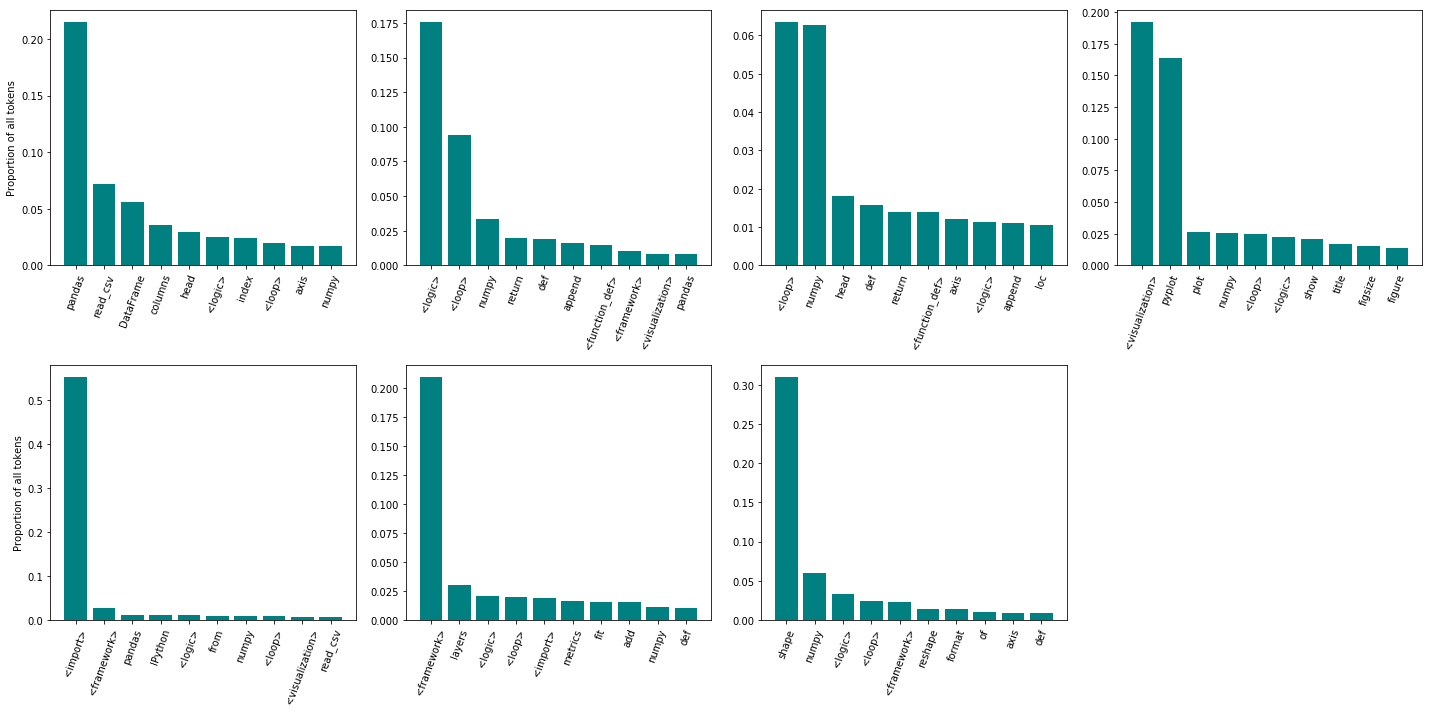

In [20]:
fig = plt.figure(figsize = (20,10))

for i in range(k):
    plt.subplot(2,4,i+1)
    top_words[i]['prop'] = top_words[i][0]/top_words[i][0].sum()
    counts = top_words[i][:10]
    x_labs = counts['index']
    x_pos = np.arange(len(x_labs))
    y = counts['prop']
    plt.bar(x_pos, y, color = 'teal')
    plt.xticks(x_pos, x_labs, rotation = 70) 
    if i in [0,4]:
        plt.ylabel('Proportion of all tokens')

plt.tight_layout()
plt.show()

- Cluster 0: data
- Cluster 1: logic and loops
- Cluster 2: other
- Cluster 3: visualization
- Cluster 4: imports
- Cluster 5: ml
- Cluster 6: other

*6 combines ml and loops. Going down to 5 clusters doesn't push the two data clusters together, but instead combines visualizations and machine learning.*

In [21]:
num_to_group = {
    -1: '',
    0: 'Data',
    1: 'Logic & Loops',
    2: 'Other',
    3: 'Visualization',
    4: 'Imports',
    5: 'Machine Learning',
    6: ''
}


if "kmeans_orders.list" in os.listdir("analysis_data/time"):
    print('Opening K Means Orders')
    with open("analysis_data/time/kmeans_orders.list","rb") as f:
        kmeans_orders = pickle.load(f)
    print("Found and opened")
else:
    # ~5.5 hours
    if "kmeans_orders_inprogress.list" in os.listdir("analysis_data/time"):
        with open("analysis_data/time/kmeans_orders_inprogress.list","rb") as f:
            kmeans_orders = pickle.load(f)
        print("Found and opened for {0} notebooks.".format(len(kmeans_orders)))
    else:
        kmeans_orders = []
    
    i = len(kmeans_orders)
    start = datetime.datetime.now()
    for c in all_processed_code[i:]:
        kmeans_orders.append([
            num_to_group[i] for i in [kmeans.predict(
            vectorizer.transform([p])
            )[0] if p != '' and type(p) == str else -1 for p in c]
        ])
        if i%10000 == 0:
            print('{0}/{1}'.format(i, len(all_processed_code)), datetime.datetime.now() - start)
            with open("analysis_data/time/kmeans_orders_inprogress.list","wb") as f:
                pickle.dump(kmeans_orders, f)
        i += 1
    print()
    end = datetime.datetime.now()
    print(end - start)
    
    start = datetime.datetime.now()
    with open("analysis_data/time/kmeans_orders.list","wb") as f:
        pickle.dump(kmeans_orders, f)
    end = datetime.datetime.now()
    print("\nSaved", end - start)

Opening K Means Orders
Found and opened


In [22]:
num_assigned = sum([sum([k != '' and k != 'Other' for k in order]) for order in kmeans_orders])
num_cells = sum([len(order) for order in kmeans_orders])
print("{0}% of cells were assigned to a topic.".format(
    round(100*num_assigned/num_cells, 2)
))

41.11% of cells were assigned to a topic.


In [23]:
def get_distribution(orders, round_dec = 1):
    
    distribution = {
        'group': [],
        'place': [],
        'count': []
    }

    for order in orders:
        count = 0
        if len(order) > 1:
            for o in order:
                placement = round(count / (len(order)-1), round_dec)
                distribution['group'].append(o)
                distribution['place'].append(placement)
                distribution['count'].append(count)
                count += 1
           
    return pd.DataFrame(distribution)

In [24]:
# 1 minute
start = datetime.datetime.now()

distribution = get_distribution(kmeans_orders)

distribution_counts = distribution.groupby(
    ['place','group']
)['count'].sum().reset_index()
distribution_total = distribution_counts.groupby(
        'place'
    )['count'].sum().reset_index().rename(
        columns={'count':'total'}
)
distribution_df = distribution_counts.merge(distribution_total, on = 'place')
distribution_df['prop'] = distribution_df['count'] / distribution_df['total']

end = datetime.datetime.now()
print(end - start)

0:01:03.626483


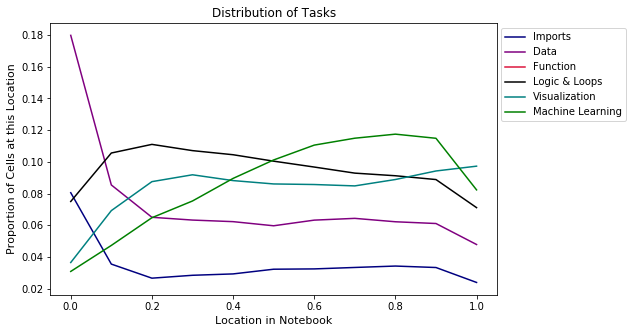

In [25]:
fig = plt.figure(figsize = (8, 5))

for task in ['Imports','Data','Function','Logic & Loops',
                       'Visualization','Machine Learning']:
    if task != '':
        x = distribution_df[distribution_df.group == task].place
        y = distribution_df[distribution_df.group == task].prop
        plt.plot(x, y, color = class_to_color[task], label = task)

plt.xlabel('Location in Notebook', fontsize = 11)
plt.ylabel('Proportion of Cells at this Location', fontsize = 11)
plt.title('Distribution of Tasks', fontsize = 12)

plt.legend(bbox_to_anchor=(1.3, 1))
plt.show()

---

## Topic Modeling: Latent Dirichlet Allocation
code reference: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [26]:
if 'lda8.model' in os.listdir('analysis_data/time'):
    print('Opening LDA Model')
    with open('analysis_data/time/lda8.model','rb') as f:
        lda_model = pickle.load(f)
    with open("analysis_data/time/lda_tfidf_corpus","rb") as f:
        corpus_tfidf = pickle.load(f)
    with open("analysis_data/time/lda_dict","rb") as f:
            dictionary = pickle.load(f)
    print("Found and opened")

else:  
    if "lda_tfidf_corpus" in os.listdir("analysis_data/time"):
        with open("analysis_data/time/lda_tfidf_corpus","rb") as f:
            corpus_tfidf = pickle.load(f)
        with open("analysis_data/time/lda_dict","rb") as f:
            dictionary = pickle.load(f)
    else:
        # 20 min
        start = datetime.datetime.now()

        # Create dictionary and corpus. Same constraints as used in K means.
        dictionary = gensim.corpora.Dictionary([i.strip().split(' ') for i in X if len(i) > 1])
        dictionary.filter_tokens(
            bad_ids = [dictionary.token2id[s] for s in stop if s in dictionary.token2id]
        )
        dictionary.filter_extremes(
            no_below = 0.01,    # don't keep tokens in under 1% of the cells
            no_above = 0.5,     # don't keep tokens in over half of the cells
            keep_n = 100        # keep 100 tokens max
        )
        bow_corpus = [dictionary.doc2bow(doc) for doc in [i.strip().split(' ') for i in X]]

        # Apply tf-idf to corpus
        tfidf = gensim.models.TfidfModel(bow_corpus)
        corpus_tfidf = tfidf[bow_corpus]

        with open("analysis_data/time/lda_tfidf_corpus","wb") as f:
            pickle.dump(corpus_tfidf, f)
            
        with open("analysis_data/time/lda_dict","wb") as f:
            pickle.dump(dictionary, f)

        end = datetime.datetime.now()
        print('TF-IDF done and saved, dictionary created', end - start)
    
    
    # 15 min
    start = datetime.datetime.now()

    lda_model = gensim.models.LdaMulticore(
        corpus_tfidf, 
        num_topics=8, 
        id2word=dictionary, 
        random_state = r
    )

    end = datetime.datetime.now()
    print('Model fitted', end - start)
    
    start = datetime.datetime.now()
    with open('analysis_data/time/lda8.model','wb') as f:
        pickle.dump(lda_model, f)
    end = datetime.datetime.now()
    print('Saved', end - start)

Opening LDA Model
Found and opened


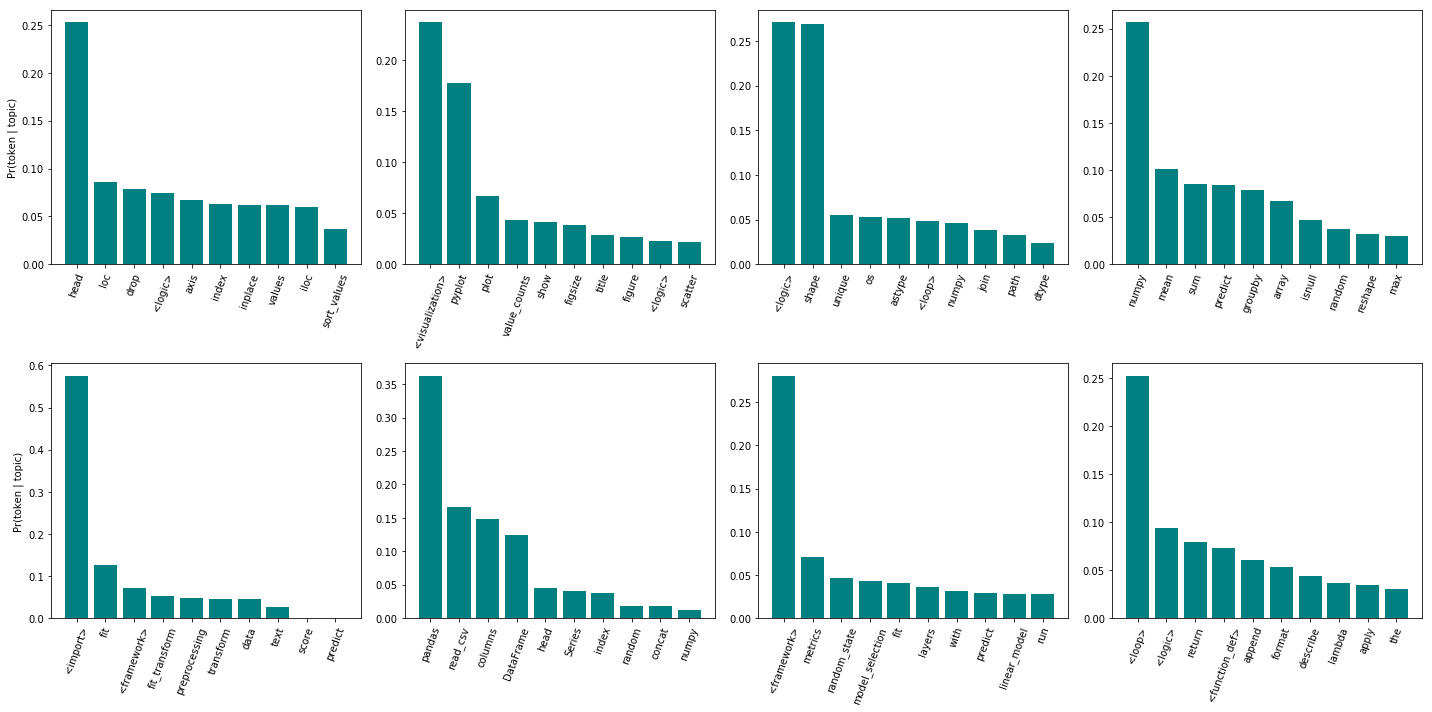

In [27]:
fig = plt.figure(figsize = (20, 10))
for i, topic in lda_model.print_topics(-1):
    x_labs = []
    y = []
    plt.subplot(2, 4, i+1)
    for t in topic.split(' + '):
        x_labs.append(t.split('*')[1].replace('"',''))
        x_pos = np.arange(len(x_labs))
        y.append(float(t.split('*')[0]))
    plt.bar(x_pos, y, color = 'teal')
    plt.xticks(x_pos, x_labs, rotation = 70)
    if i in [0, 4]:
        plt.ylabel('Pr(token | topic)')
    
plt.tight_layout()
plt.show()

- Topic 0: data
- Topic 1: visualization
- Topic 2: other
- Topic 3: other
- Topic 4: imports
- Topic 5: data
- Topic 6: ml
- Topic 7: loops and logic

* 5 topics combines machine learning, imports, and visualizations. 6, 7 topics logic and loops and data, 8, 9, 10 topics combines machine learning and imports*

In [28]:
num_to_group = {
    0: 'Data',
    1: 'Visualization',
    2: '',
    3: '',
    4: 'Imports',
    5: 'Data',
    6: 'Machine Learning',
    7: 'Logic & Loops'
}

if "lda_distrib.csv" in os.listdir('analysis_data/time'):
    print('Opening')
    lda_distrib = pd.read_csv('analysis_data/time/lda_distrib.csv')
    print("Found and opened")
else:
    lda_distrib = {
        'place': [],
        'task': [],
        'weight': []
    }
    lda_total = []
    num_inprogress = 0
        
    i = num_inprogress
    start = datetime.datetime.now()
    for processed_code in all_processed_code[i:]:
        j = 0
        for cell in processed_code:
            place = round(j/len(processed_code), 1)
            scores = sorted(lda_model[dictionary.doc2bow(cell.strip().split(' '))], key = lambda x: -1*x[1])
            for score in scores:
                lda_distrib['place'].append(place)
                lda_distrib['task'].append(num_to_group[score[0]])
                lda_distrib['weight'].append(score[1])
            lda_total.append(place)
            j += 1
        if i%10000 == 0:
            print('{0}/{1}'.format(i, len(all_processed_code)),  datetime.datetime.now() - start)
            with open('analysis_data/time/lda_distrib_inprogress.dict','wb') as f:
                pickle.dump(lda_distrib, f)
            with open('analysis_data/time/lda_total_inprogress.list','wb') as f:
                pickle.dump(lda_total, f)
            with open('analysis_data/time/lda_num_inprogress','wb') as f:
                pickle.dump(i, f)
        i += 1
    end = datetime.datetime.now()
    print(end - start)

    start = datetime.datetime.now()
    with open('analysis_data/time/lda_distrib.dict','wb') as f:
        pickle.dump(lda_distrib, f)
    with open('analysis_data/time/lda_total.list','wb') as f:
        pickle.dump(lda_total, f)
    end = datetime.datetime.now()
    print("Saved", end - start)

Opening
Found and opened


In [29]:
lda_distrib.task = lda_distrib.task.fillna('')
print("{0}% of cells were assigned at least one task.".format(
    round(100*lda_distrib[lda_distrib.task != '']['count'].sum() / lda_distrib['count'].sum(), 2)
))

77.28% of cells were assigned at least one task.


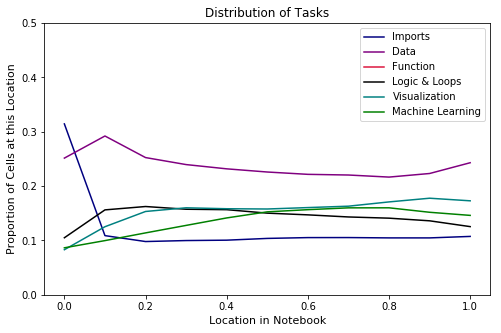

In [30]:
fig = plt.figure(figsize = (8, 5))

for task in ['Imports','Data','Function','Logic & Loops',
                       'Visualization','Machine Learning']:
    if task != '':
        x = lda_distrib[lda_distrib.task == task].place
        y = lda_distrib[lda_distrib.task == task].prop
        plt.plot(x, y, color = class_to_color[task], label = task)

plt.xlabel('Location in Notebook', fontsize = 11)
plt.ylabel('Proportion of Cells at this Location', fontsize = 11)
plt.title('Distribution of Tasks', fontsize = 12)
plt.ylim(0, 0.5)

plt.legend()
plt.show()

---

[Jupyter Standards &lt;](13_Standards.ipynb) | [&gt; Exploring Interactive Subsets](15_Interactive.ipynb)